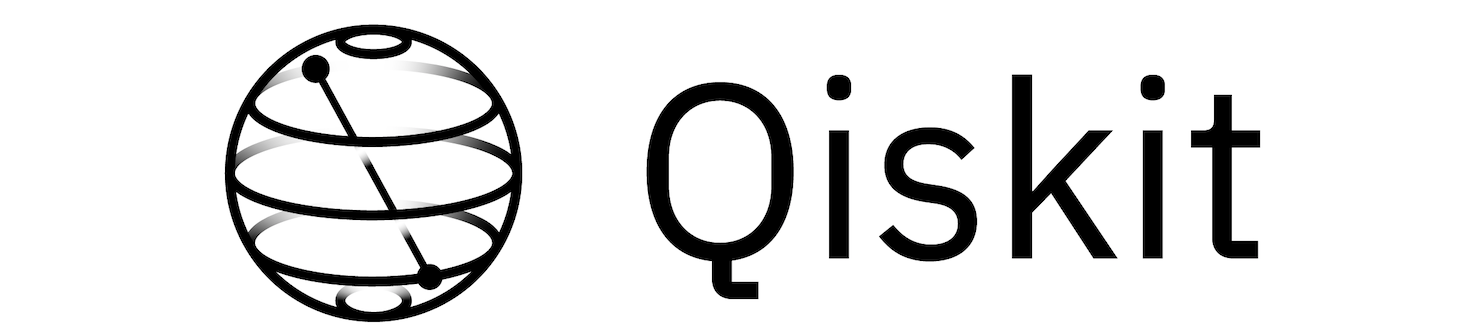

# <h1 style="text-align:center; font-size: 45px;"> An introduction to Qiskit</h1>
### <p style="text-align:center;"> Davood Haji Taghi Tehrani, Lukas Helmig</p>
### <p style="text-align:center;"> 03.05.2023</p>
 <p style="text-align:center;"> Advanced Seminar on Quantum Computing: Entanglement, Measurement and Quantum Simulations</p>

### Outline

1. Basic circuit building
2. Simulators and transpile
3. Running a circuit on a quantum computer at IBM
4. Modeling noise with Qiskit
5. Transverse field Ising model
6. Conclusion


### What is Qiskit?

* Qiskit is an open-source SDK, founded by IBM in 2017
* developed in python, but versions in swift and javascript exist
* can be used for any universal quantum turing machine



* organized into Terra (Quantum Circuits), Aer (Simulations), Ignis (Quantum hardware verification) and Aqua (Algorithms for quantum applications)
* alternatives: Cirq from Google and Q# from Microsoft

### <h2 style="text-align:left;"> Basic Example</h2>
 $\left|\psi\right\rangle = \hat H \left|0\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle + \left|1 \right\rangle\right)$ 

In [ ]:
from qiskit import * # Not a good practice, but we do it here anyways

def make_circuit(a, c): # Step 1: Build a Quantum Circuit
    qb = QuantumRegister(a, "QB") # Qubit(s)
    cb = ClassicalRegister(c, "CB") # Classical bit(s)
    circuit =  QuantumCircuit(qb, cb) 
    return circuit, qb, cb

def do_simulation(circuit, backend, shots): # Step 2: Run it!
    simulator = Aer.get_backend(backend) # Pick this backend
    compiled_circuit = transpile(circuit, simulator) # Prepare this circuit for this backend
    job = simulator.run(compiled_circuit, shots=shots) # Computethe result
    return job.result() # Return the result

In [2]:
circuit, qb, cb = make_circuit(1, 1)
circuit.h(qb[0]) # Apply Hadamard gate on 0th Qubit
circuit.measure(qb, cb) # Add measurement on qubit(s) and classical bit(s)
circuit.draw() # Use mpl or latex

┌───┐┌─┐
  QB: ┤ H ├┤M├
      └───┘└╥┘
CB: 1/══════╩═
            0

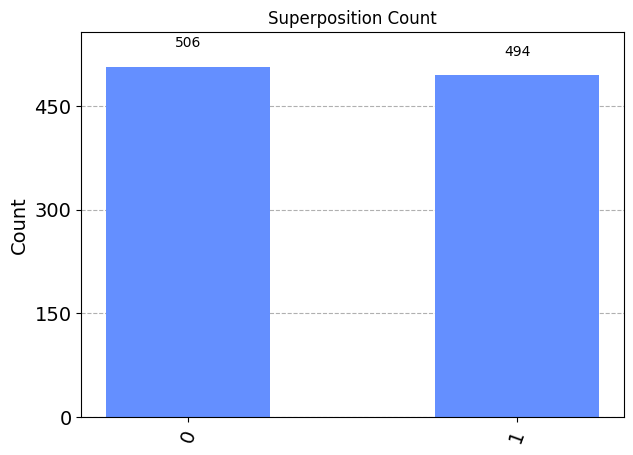

In [3]:
from qiskit.visualization import plot_histogram 

result = do_simulation(circuit, "aer_simulator", 1000).get_counts() # aer_simulator is general purpose simulator
plot_histogram(result, title='Superposition Count')

### <h2 style="text-align:left;">Parameterised Gate</h2>

In [4]:
import numpy as np
from qiskit.circuit import Parameter

n = 5 #Number of Qubits
theta = Parameter('θ') #Rotate the system  
circuit, qb, cb = make_circuit(n, 1)
circuit.h(qb[0])
for i in range(n-1):
    circuit.cx(i, i+1)

circuit.barrier()
circuit.rz(theta, range(n))
circuit.barrier()

for i in reversed(range(n-1)):
    circuit.cx(i, i+1)
    
circuit.h(0)
circuit.measure(0, 0)

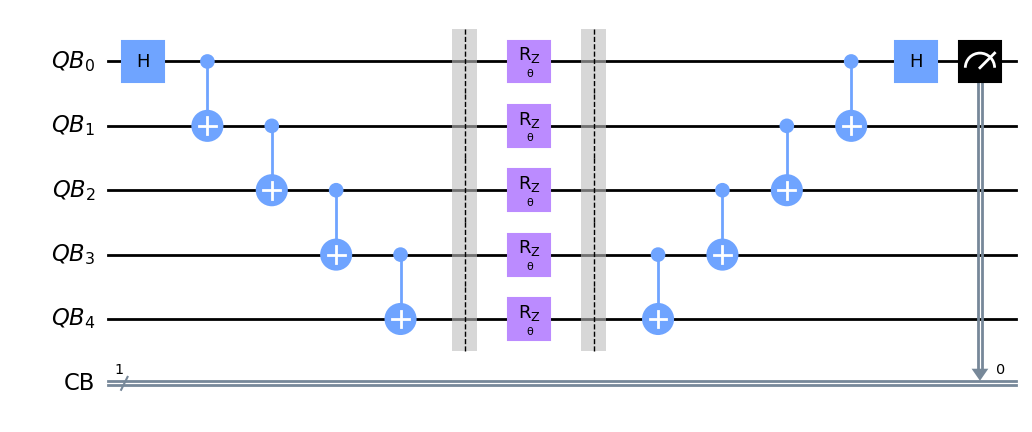

In [5]:
circuit.draw('mpl')

In [6]:
import matplotlib.pyplot as plt

theta_range = np.linspace(0, 2 * np.pi, 128)
circuits = [circuit.bind_parameters({theta: theta_val}) for theta_val in theta_range]
reuslt = do_simulation(circuits, "aer_simulator", 1000).get_counts()

fig = plt.figure(figsize=(8,6))
# dont show figure yet
plt.close(fig)

ax = fig.add_subplot(111)
ax.plot(theta_range, list(map(lambda c: c.get('0', 0), reuslt)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), reuslt)), '.-', label='1')
ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize = 14)

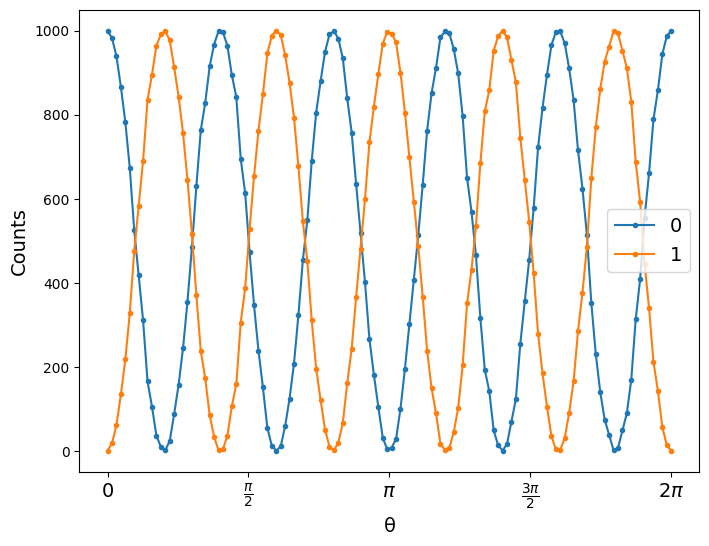

In [7]:
fig

### <h2 style="text-align:left;">Visualization</h2>

In [8]:
from qiskit.visualization import plot_state_paulivec, plot_state_city, plot_bloch_multivector, plot_state_hinton, plot_state_qsphere

bell = make_circuit(2, 2)[0]
bell.h(0)
bell.cx(0, 1)

result = do_simulation(bell, 'statevector_simulator', 1000).get_statevector()

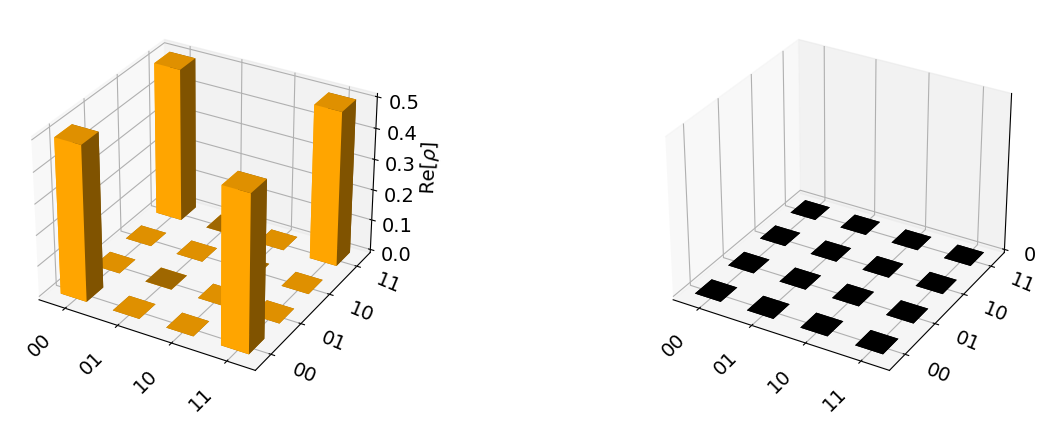

In [9]:
plot_state_city(result, color=['orange', 'black'])

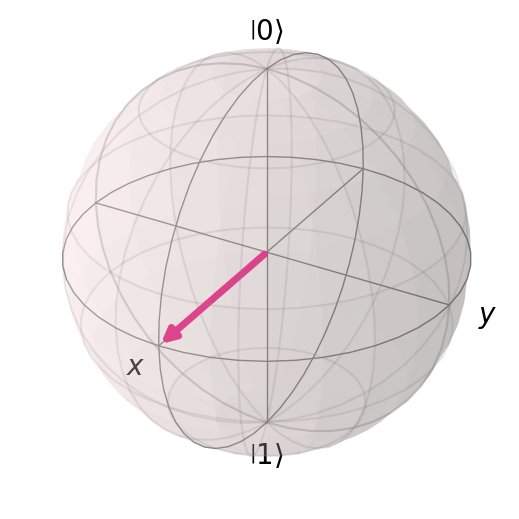

In [10]:
from qiskit.visualization import plot_bloch_vector
plot_bloch_vector([1,0,0])

<h4 style="text-align:center; font-size: 45px;"> Simulators and Transpile</h4>

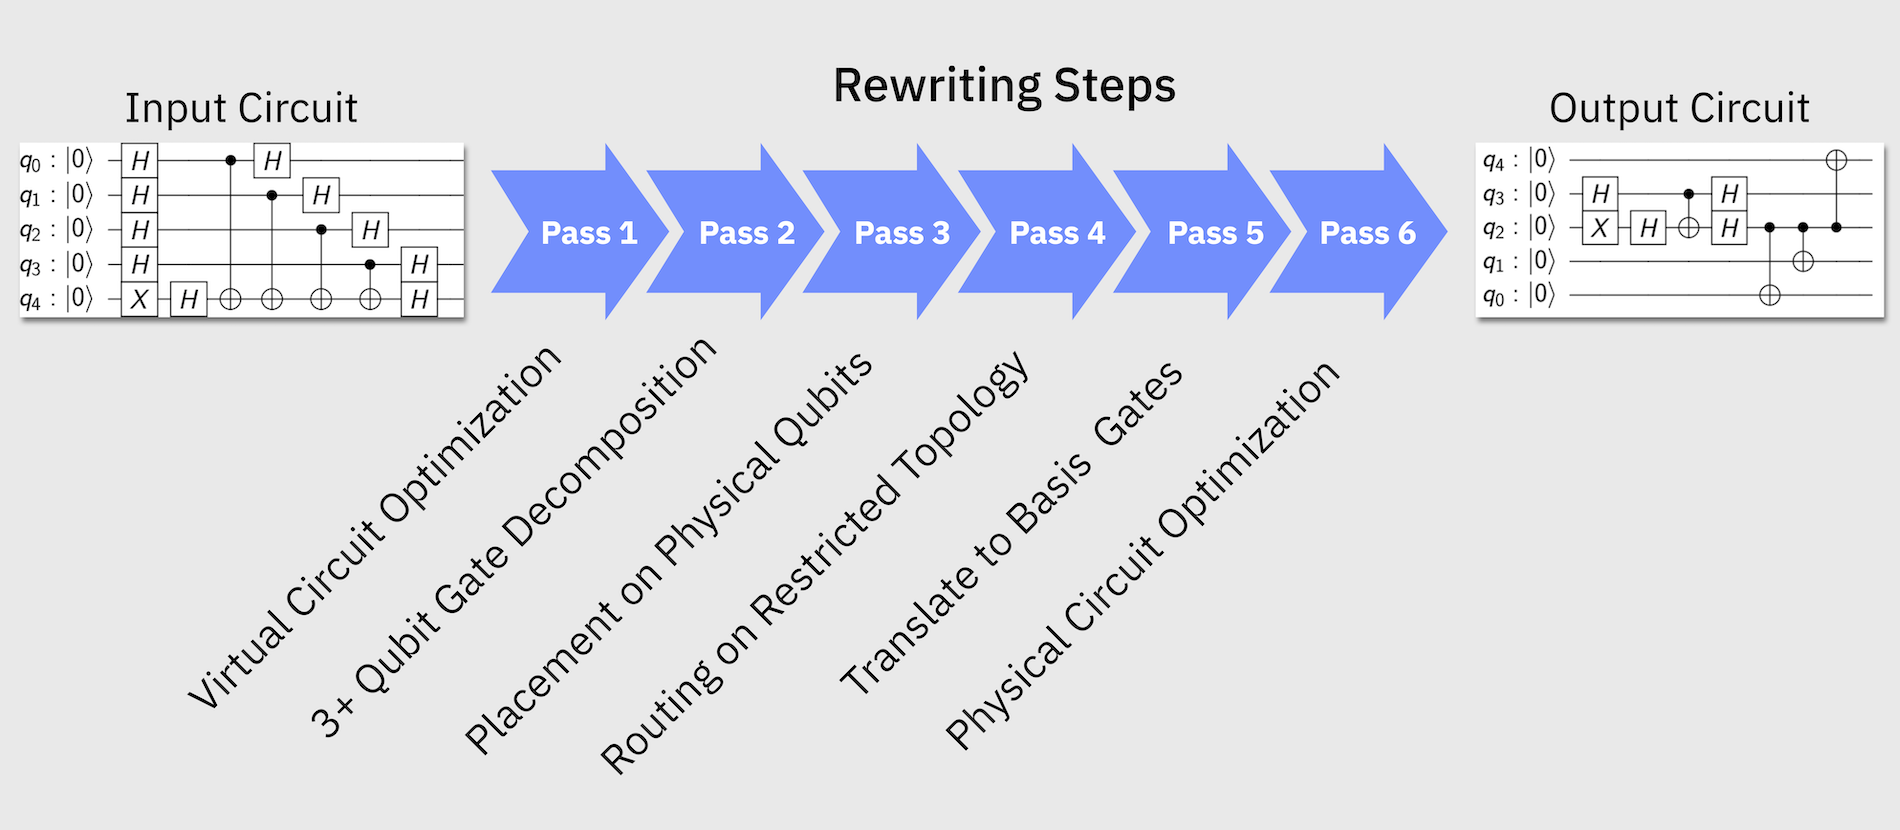

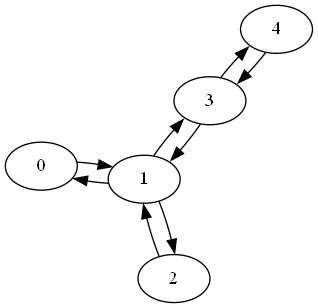

In [1]:
from qiskit.providers.fake_provider import * # Simulate real backends

fake_backend = FakeVigoV2()
fake_backend.coupling_map.draw()

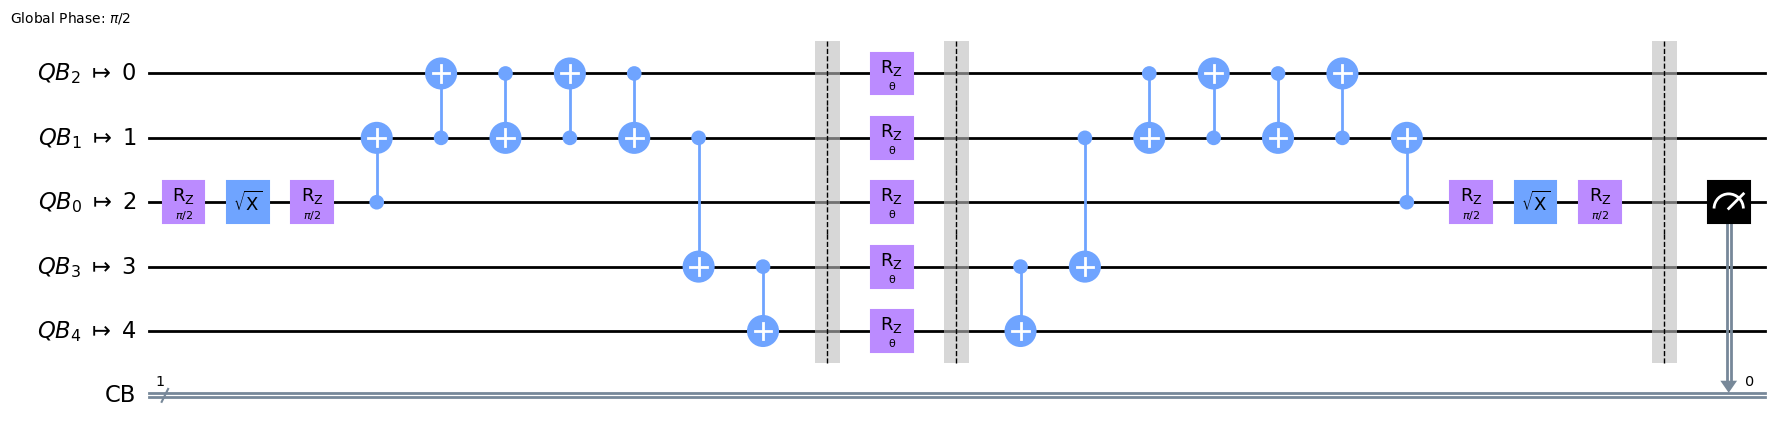

In [12]:
compiled_circuit = transpile(circuit, fake_backend)
compiled_circuit.draw('mpl')

In [13]:
Aer.aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [14]:
bell_state = make_circuit(2, 2)[0]
bell_state.h(0)
bell_state.cx(0, 1) # Bell State
bell_state.measure([0, 1], [0, 1])
simulators = ['aer_simulator_stabilizer', 'aer_simulator_statevector', 'aer_simulator_density_matrix', 'aer_simulator_matrix_product_state']
results_bell_state = [do_simulation(bell_state, simulator, 4000).get_counts() for simulator in simulators]

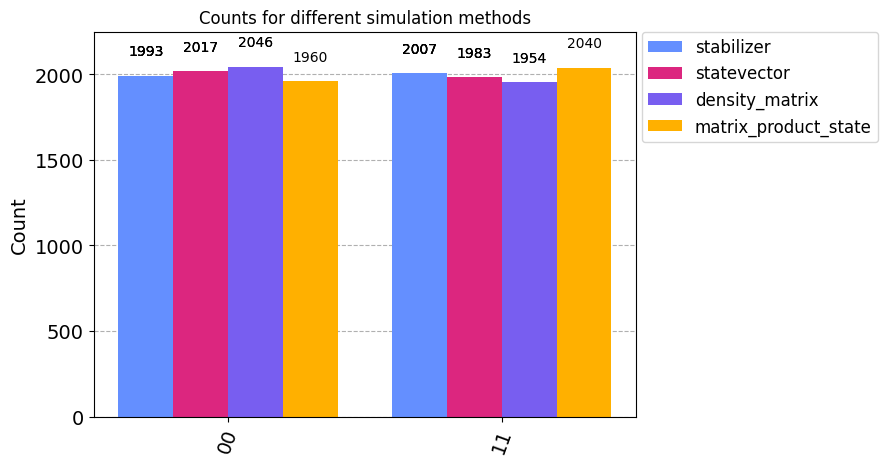

In [15]:
plot_histogram(results_bell_state, title='Counts for different simulation methods', legend=['stabilizer', 'statevector','density_matrix', 'matrix_product_state'])

<h4 style="text-align:center; font-size: 45px;"> Accessing real backends at IBM</h4>

## Using the 'qiskit-ibm-provider' package to access IBM's quantum systems

* We'll use ```qiskit-ibm-provider``` to gain access to IBM's quantum systems

* install package via ```pip install qiskit-ibm-provider``` (not included in qiskit package)

* make an account at https://quantum-computing.ibm.com/


First, we need to import the **IBMProvider** class

In [16]:
# We will only use the IMBProvider class from the package

from qiskit_ibm_provider import IBMProvider

We can permanently save our access token in a JSON file by calling once

In [ ]:
token = '_'

IBMProvider.save_account(token=token)

print("saved")

saved


In [21]:
# we might want to delete stored account info
IBMProvider.delete_account()

True

which will create a json file ```qiskit-ibm.json```, where the access token is stored. We can now get an instance of ```IBMProvider``` by writing

In [ ]:
provider = IBMProvider()

But you can also choose to activate your account only for the current session by calling

In [22]:
provider = IBMProvider(token=token)

To check what account we are currently using, call

In [23]:
provider.active_account()

{'channel': 'ibm_quantum',
 'token': '14852dc441da18da254835e32027a0ee8d238332f3f60e31f74453c9511f58936d26221fbddbac917aee278c14af26e6ddaba0b6a03d7c6a768852ef5e069c83',
 'url': 'https://auth.quantum-computing.ibm.com/api',
 'verify': True,
 'instance': 'ibm-q/open/main'}

Once we have an instance of ```IBMProvider```, we can access all functionalities

* look up/send jobs
* access/get backends

Documentation is incomplete, but the main part can be found [here](https://github.com/Qiskit/qiskit-ibm-provider/blob/main/docs/tutorials/1_the_ibm_quantum_account.ipynb).

We can also get a list of all backends (real quantum devices or simulators) we have access to

In [24]:
provider.backends()

[<IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_belem')>]

In [ ]:
provider.backends(simulator = False)
provider.backends(min_num_qubits=5)
provider.backends(min_num_qubits=8, simulator = False)

<h4 style="text-align:center; font-size: 45px;"> Submitting a job to run at IBM</h4>

### Submit a job to a backend

In [25]:
from qiskit_ibm_provider import least_busy

In [26]:
# first, we need to get our backend

#in this case, we use the least_busy method

backend = least_busy(provider.backends(simulator = False))

print(backend)

# transpile the circuit with our backend

tp_qc = transpile(bell_state, backend)

<IBMBackend('ibm_nairobi')>


#### To run a circuit, call ```backend.run(transpiled_circuit, shots)```

In [27]:
# runs the transpiled circuit on our chosen backend

job = backend.run(tp_qc, shots=4000)

# we can save the job id, or simply look it up in our dashboard

job_id = job.job_id()

print(job_id)

ch5qmpp7o5gvn6qe0n10


In [28]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [29]:
job.queue_info()

<QueueInfo(job_id='None', _status='QUEUED', estimated_start_time='2023-04-29T16:50:16.751000+02:00', estimated_complete_time='2023-04-29T20:50:21.751000+02:00', position=6, hub_priority=None, group_priority=None, project_priority=None)>

In [ ]:
# you can halt the code until the job has finished

job.wait_for_final_state()

Now we take a quick look into our dashboard and see if our submitted job is showing up there!

The job will likely not be finished at the end of our presentation, so we will use an old one! 

use the ```retrieve_job()``` method:

In [30]:
job_old_bell = provider.retrieve_job("cgun0gpi3rtni0qmmc8g")

How can we get the measurement data from our job?

In [31]:
job_old_bell.result() # add get_counts()

Result(backend_name='ibm_perth', backend_version='1.2.2', qobj_id='e0f8d5bb-36f4-44eb-8d04-63c81d529893', job_id='circuit-runner_cgun0gpi3rtni0qmmc8g_4e9f_0', success=True, results=[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 1824, '0x1': 286, '0x2': 259, '0x3': 1631}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]], n_qubits=7, qreg_sizes=[['q', 7]], clbit_labels=[['meas', 0], ['meas', 1]], memory_slots=2, creg_sizes=[['meas', 2]], name='circuit-90', global_phase=0.7853981633974483, metadata={}), status=done)], date=2023-04-17 19:16:08+02:00, status=Successful completion, header=QobjHeader(backend_name='ibm_perth', backend_version='1.2.2', _ibm_tracing_={'uber-trace-id': '73a67edf602e6930597148cd230fda80:9c13938445a5acd9:5ec9f48f35cdd4f0:1'}), execution_id='6eed3022-dd43-11ed-bc0c-b02628ea1e00', time_taken=46.705499800999995, error=None)

### Results of our submitted job

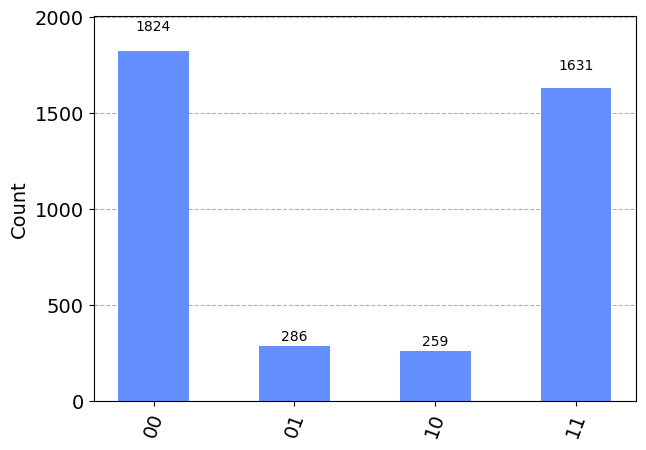

In [32]:
plot_histogram(job_old_bell.result().get_counts())

<h4 style="text-align:center; font-size: 45px;"> Modeling noise with Qiskit</h4>

### The NoiseModel class and how to build a custom model for noise

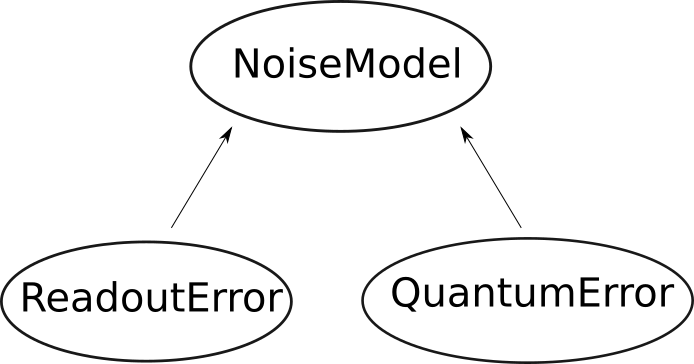

The NoiseModel, ReadoutError and QuantumError class

### The NoiseModel class and how to build a custom model for noise

A great introduction into modeling noise in qiskit is given in the [docs](https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html)

* The ```NoiseModel``` class stores all of the properties about our NoiseModel
* We can use the ```QuantumError``` class to build CPTP gate errors (CPTP stands for "**c**ompletely **p**ositive and **t**race **p**reserving" linear maps $\Phi$ from $\mathcal{H}_A$ to $\mathcal{H}_B$ in a quantum channel)
* With ```ReadoutError``` classical readout errors can be modeled

### Standard error functions to build a ```QuantumError```

$$
\begin{aligned}
&\begin{array}{|l|}
\hline
\textbf{Standard error functions} \\
\hline \hline
\text{pauli_error(arg)} \\
\text{mixed_unitary_error(arg)} \\
\text{kraus_error(arg)} \\
\hline
\text{reset_error(arg)} \\
\text{depolarizing_error(arg)} \\
\hline
\text{thermal_relaxation_error(arg)}\\
\hline
\end{array}
\end{aligned}
$$

In [33]:
# import all the stuff we need
from qiskit_aer import AerSimulator, noise

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, pauli_error, depolarizing_error, thermal_relaxation_error)

### Building a bit-flip error

In [35]:
p_error = 0.15

error_x = pauli_error([('X',p_error),('I', 1-p_error)])

print(error_x)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.15, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.85, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [ ]:
#probability that a bit flip occurs
p_bit_flip = 0.15

# use standard error function to build a QuantumError
error_x = pauli_error([('X',p_bit_flip),('I',1-p_bit_flip)])

# print out the quantum error we just constructed!
print(error_x)

### Building a phase-flip error

In [36]:
#probability that a phase flip occurs
p_phase_flip = 0.15

# use standard error function to build a QuantumError
error_z = pauli_error([('Z',p_phase_flip),('I',1-p_phase_flip)])

# print out the quantum error we just constructed!
print(error_z)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.15, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.85, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


### Combined XZ error

In [37]:
# Composition of X and Z error, ZX
error_xz = error_x.compose(error_z)
print(error_xz)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.022500000000000003, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.12750000000000003, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.12750000000000003, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.7225, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


### Bit-flip error on two qubits

In [38]:
error_xx = error_x.tensor(error_x)

In [39]:
print(error_xx)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.022500000000000003, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(1) = 0.12750000000000003, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(2) = 0.12750000000000003, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.7225, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


### Thermal relaxation error

In [ ]:
T1 = 158.88 # in us, actual T1 time of ibm_perth
T2 =  88.66 # in us, actual T2 time of ibm_perth

gate_time = 200

relax_error = thermal_relaxation_error(T1,T2,gate_time)

### Thermal relaxation error

In [ ]:
print(relax_error)

### Depolarizing error

$$E(\rho) = (1-\lambda)\rho + \lambda Tr[\rho] \frac{I}{2^n}$$

In [ ]:
lambda_val = 0.5

depol_err = depolarizing_error(lambda_val,1)

### Depolarizing error

In [ ]:
print(depol_err)

### Adding errors to a noise model

Specify, if the ```QuantumError``` acts on

* all qubits $\implies$  ```add_all_qubit_quantum_error(error, instructions)```
* only single qubits $\implies$ ```add_quantum_error(error, instructions, qubits)```


A noise model is always defined for a (default) set of basis gates:

In [40]:
# create an instance of a noise model

noise_model = NoiseModel()

# get basis gates of noise model (instructions)

print(noise_model.basis_gates)

['cx', 'id', 'rz', 'sx']


When we add errors to a noise model, we always need to specify after which operation an error could potentially occur:

In [41]:
# we add the previously constructed error_x to our noise model
# as the instruction parameter, we hand over all 1 qubit basis_gates

noise_model.add_all_qubit_quantum_error(error_x, ['id', 'rz', 'sx'])

# we add the error_x also as an error source after the controlled x operation
# to do that we need to build a error_x.tensor(error_x)

noise_model.add_all_qubit_quantum_error(error_x.tensor(error_x), ['cx'])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'sx', 'id', 'rz']
  All-qubits errors: ['id', 'rz', 'sx', 'cx']


### Example: simulating the circuit with noise

In [42]:
# create a backend with a simulation method ('density_matrix') in this case
# and the noise model we just created

backend = AerSimulator(method='density_matrix', noise_model = noise_model)

# transpilation step
tp_qc = transpile(bell_state, backend)

# starting the simulation with the transpiled circuit, and runs = 2000
result_noise = backend.run(tp_qc, shots = 4000).result()

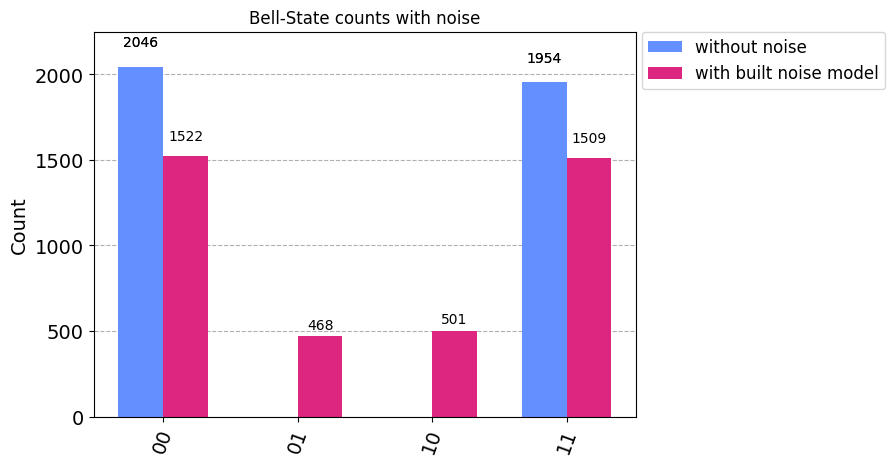

In [43]:
plot_histogram([results_bell_state[2],result_noise.get_counts()], legend = ["without noise", "with built noise model"], title='Bell-State counts with noise')

<h4 style="text-align:center; font-size: 45px;"> Noise models of real devices</h4>

### Noise models for real quantum devices

In [44]:
# import the noise model modul from the aer simulator

from qiskit.providers.aer.noise import NoiseModel

In [45]:
# get ibm_perth backend
backend = provider.get_backend("ibm_perth")

# get the noise model for the ibm_perth machine

noise_model_perth = NoiseModel.from_backend(backend)

We get classical readout errors easily from the noise model

In [46]:
# we can take a look at the read out errors
print(noise_model_perth._local_readout_errors)

{(0,): ReadoutError([[0.9739 0.0261]
 [0.0261 0.9739]]), (1,): ReadoutError([[0.9754 0.0246]
 [0.0246 0.9754]]), (2,): ReadoutError([[0.9798 0.0202]
 [0.0202 0.9798]]), (3,): ReadoutError([[0.9827 0.0173]
 [0.0173 0.9827]]), (4,): ReadoutError([[0.9834 0.0166]
 [0.0166 0.9834]]), (5,): ReadoutError([[0.977 0.023]
 [0.023 0.977]]), (6,): ReadoutError([[0.9884 0.0116]
 [0.0116 0.9884]])}


But printing out quantum errors of the noise model can not be done directly. However, we can print out the gate errors from a backend

In [65]:
props = backend.properties() # properties of IBM perth

props.gate_error('sx', 0) # printing out the error rates for a specific qubit

0.0005381668139782362

### Run bell circuit with a noise model from a real device

In [47]:
backend = AerSimulator(method='statevector', noise_model = noise_model_perth)

# transpilation step
tp_qc = transpile(bell_state, backend)

# starting the simulation with the transpiled circuit, and runs = 2000
result_simulation = backend.run(tp_qc, shots = 4000).result()

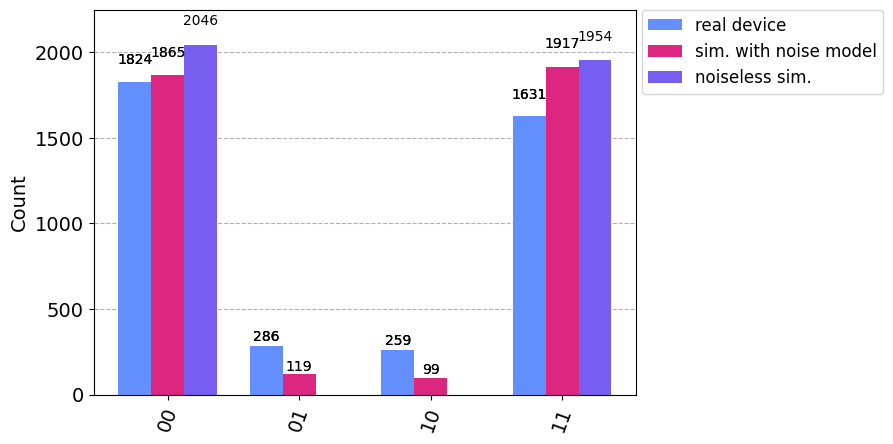

In [48]:
plot_histogram([job_old_bell.result().get_counts(),result_simulation.get_counts(), results_bell_state[2]], legend = ["real device", "sim. with noise model", "noiseless sim."])

### Transverse-field Ising model

$$\large \hat{H}= -J\sum_{i}\hat{\sigma}_i^z\hat{\sigma}_{i+1}^z - b\sum_i \hat{\sigma}_i^x$$

### Time evolution
$$\large \hat{H} \left|\psi\right\rangle = i\frac{d}{dt} \left|\psi\right\rangle$$
<br>
$$\large e^{-i \hat{H}t} \left|\psi(0)\right\rangle = \left|\psi(t)\right\rangle$$

### Trotter-Suzuki approximation

$$\large e^{-i\hat{H}t} \approx (e^{-i \hat{H}dt})^N + O(dt^2)= \left(\prod_{j} e^{iJ \hat{\sigma}_j^z\hat{\sigma}_{j+1}^zdt}\prod_{j} e^{ib \hat{\sigma}_j^xdt}\right)^N $$
<br>
$$\large = \left(\prod_j R_{z_jz_{j+1}}(2Jdt)  \prod_j R_{x_j}(2bdt)\right)^N = \left(\prod_j R_{z_jz_{j+1}}(\theta)  \prod_j R_{x_j}(\phi)\right)^N$$

### Parameter of the approximation

In [49]:
N = 400 # N times operate this set of operators
n = 4 # Number of Qubits & Classical Bits

dt = 100/N
J = 1 # Normalized by hbar
b = 0.5 # Normalized by hbar

theta = -2*J*dt # Normalized by hbar
phi = -2*b*dt # Normalized by hbar

In [50]:
def create_ising_circuit(N, n, dt, J, b):
    
    qcs = [] # we create circuits with 1 step up to N steps of the time evolution
    
    for i in range(1, N):
        qc, qb, cb = make_circuit(n, n) # we create a circuit with n qubits, n classical bits

        for j in range(i): # do for each layer
            
            qc.rx(phi, range(n))        # finish first layer

            for k in range(n-1):       # start a new layer
                if(k % 2 == 0):        # on odd qubits

                    qc.rzz(-2*J * dt, qb[k], qb[k+1])  

            for k in range(n-1):       # new layer on even qubits

                if(k % 2 != 0):

                    qc.rzz(-2*J * dt, qb[k], qb[k+1])
                    qc.barrier()              


        qc.measure(qb, cb)
        qcs.append(qc)
    return qcs

In [51]:
qcs = create_ising_circuit(N, n, dt, J, b)

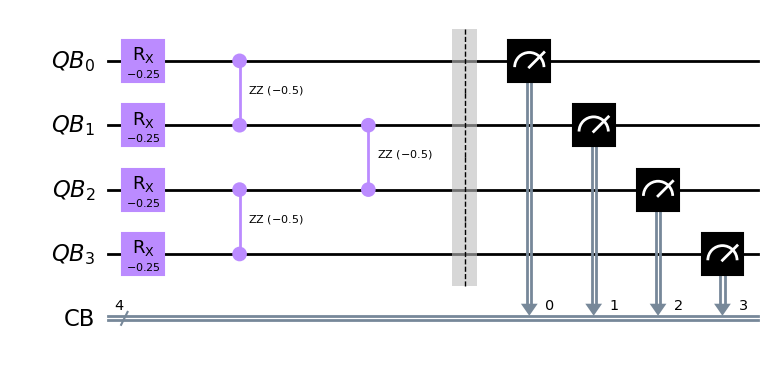

In [52]:
f = qcs[0]
f.draw('mpl')

In [53]:
def calc_magnetization_from_dics(array_dic, num_samples):
    
    magnetization = []
    
    for dic in array_dic:
        m = 0
        for key in dic:
            spins = np.array([int(spin) for spin in key])
            spins[spins == 1] = -1
            spins[spins == 0] = 1
            m = m + np.sum(spins)*dic[key]/num_samples
        magnetization.append(m)
    
    return magnetization

### Simulation of the Ising chain

In [54]:
%%time

num_samples = 1000
last = do_simulation(qcs, "aer_simulator", num_samples).get_counts()

CPU times: total: 4min 4s
Wall time: 4min 4s


In [63]:
magnetization = calc_magnetization_from_dics(last, num_samples)

fig = plt.figure(figsize=(8,6))

plt.close()

ax = fig.add_subplot()
ax.plot(magnetization)
ax.set_title("Time evolution of magnetization")

Text(0.5, 1.0, 'Time evolution of magnetization')

### Simulation of the Ising chain

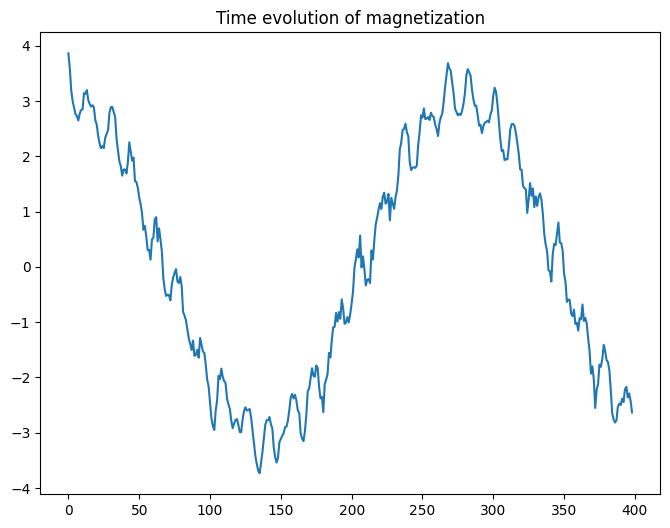

In [64]:
fig

In [90]:
import numpy as np
import matplotlib.pyplot as plt

magnetization_wo_noise = np.loadtxt("simulation_N=400_dt=100.txt")
magnetization_noise_manila = np.loadtxt("simulation_noise_manila_N=200_dt=50.txt")

job = provider.retrieve_job("ch3bg41pleju56fe0a80")
counts = job.result().get_counts()
magnetization_manila = calc_magnetization_from_dics(counts,4000)

fig = plt.figure(figsize=(8,6))

plt.close()

ax = fig.add_subplot()
ax.plot(magnetization_wo_noise, label = "without noise")
ax.plot(magnetization_noise_manila, label = "with noise model of ibmq_manila")
ax.plot(magnetization_manila, label = "ibmq_manila")
ax.set_title("Time evolution of magnetization")
ax.set_xlim([0,25])
ax.legend()

### Simulation of the Ising model on ibmq_manila

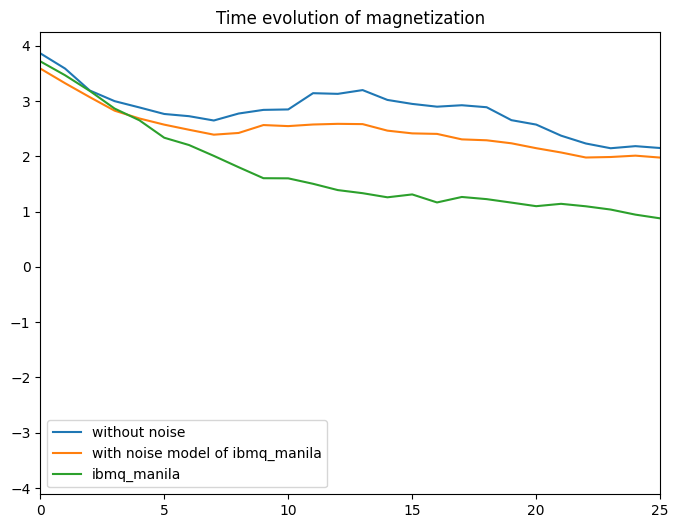

In [91]:
fig

### Simulation of the Ising model on ibmq_manila

$\implies$ imbq_manila has the optimal topology (or coupling map) for our problem

> Quantum Volume: $V_Q = \log_2 V^{\text{IBM}}_Q = \max_{n<N}[\min(n,d(n))^2]$

$V_Q$ of manila is $32 = 2^5$, so we should definitely be able to simulate a 5x5 square circuit!

### Conclusion

* building circuits is very straightforward
* running circuits on real quantum computers is simple and accessible
* backends at IBM are very noisy and not really suited for physical simulations yet
* noise models do not fully capture the noise of a real device
* state of the documentation is poor and lacks scientific depth

### Simulation of the Ising model on ibmq_manila

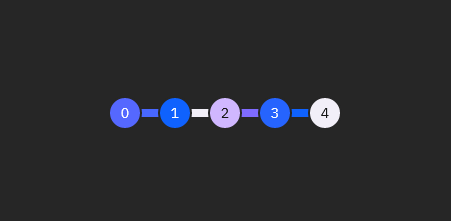

Coupling map on ibmq_manila

### Simulation of the Ising model on ibmq_manila

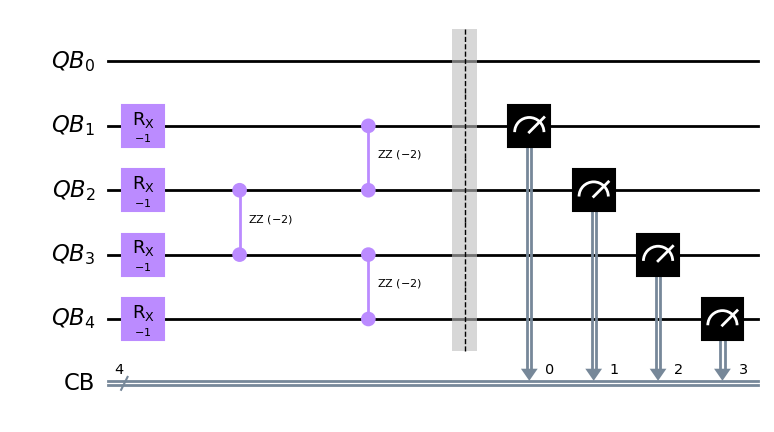

One layer of the Ising chain simulation on ibmq_manila

### Simulation of the Ising model on ibmq_manila

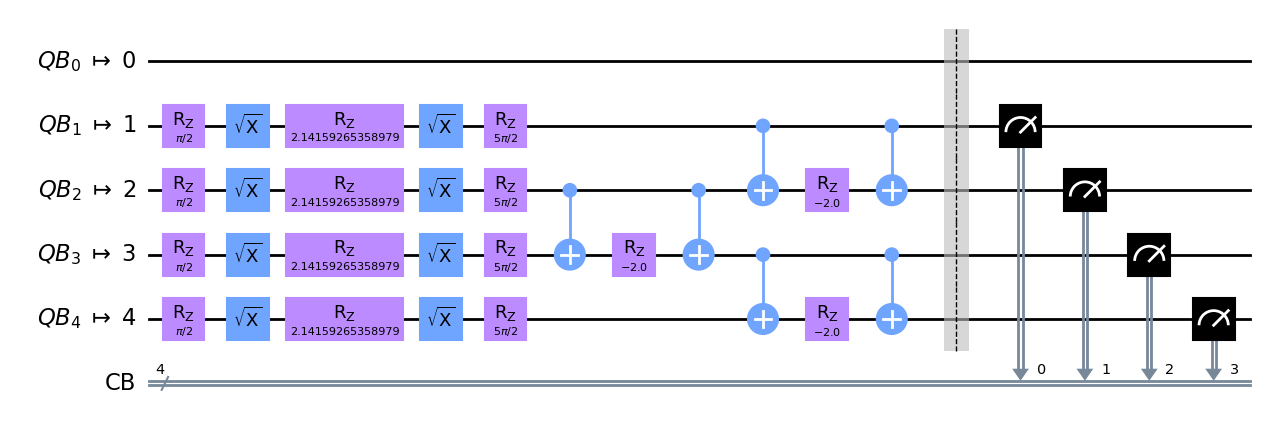

Transpiled layer of the Ising chain simulation on ibmq_manila

### Simulation of the Ising model on ibm_lagos

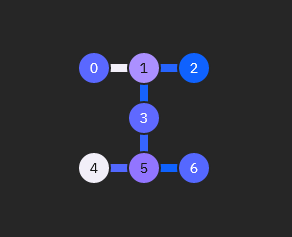

Coupling map on ibm_lagos

### Simulation of the Ising model on ibm_lagos

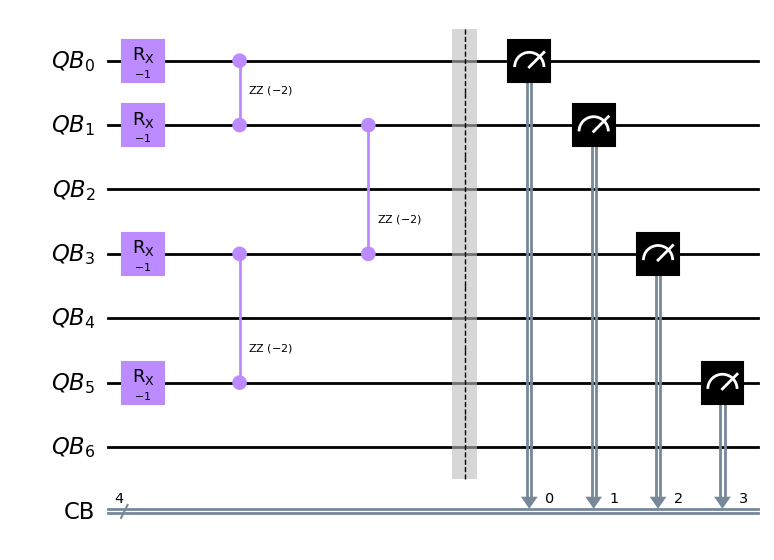

One layer of the Ising chain simulation on ibm_lagos

### Simulation of the Ising model on ibm_lagos

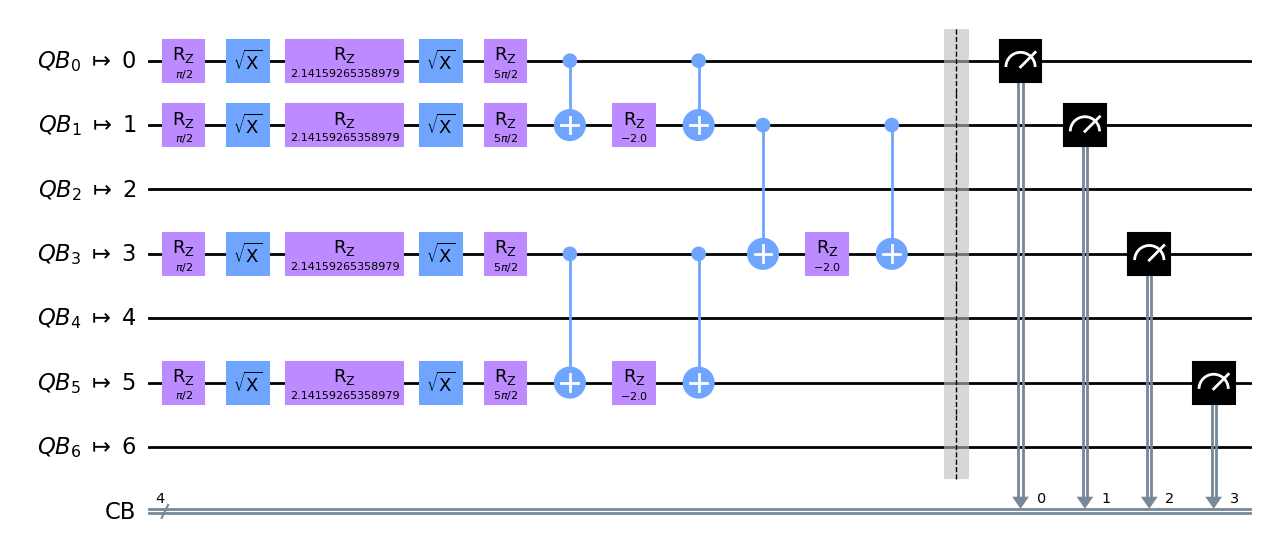

Transpiled layer of the Ising chain simulation on ibm_lagos

In [79]:
magnetization_wo_noise = np.loadtxt("simulation_N=400_dt=100.txt")
magnetization_noise_manila = np.loadtxt("simulation_noise_lagos_N=200_dt=50.txt")

job = provider.retrieve_job("ch3depo5ngm0qhdt1090")
counts = job.result().get_counts()
magnetization_lagos = calc_magnetization_from_dics(counts,4000)

fig = plt.figure(figsize=(8,6))

plt.close()

ax = fig.add_subplot()
ax.plot(magnetization_wo_noise, label = "without noise")
ax.plot(magnetization_noise_manila, label = "with noise model of ibmq_manila")
ax.plot(magnetization_lagos, label = "ibmq_lagos")
ax.set_title("Time evolution of magnetization")
ax.set_xlim([0,200])
ax.legend()

### Simulation of the Ising model on ibm_lagos

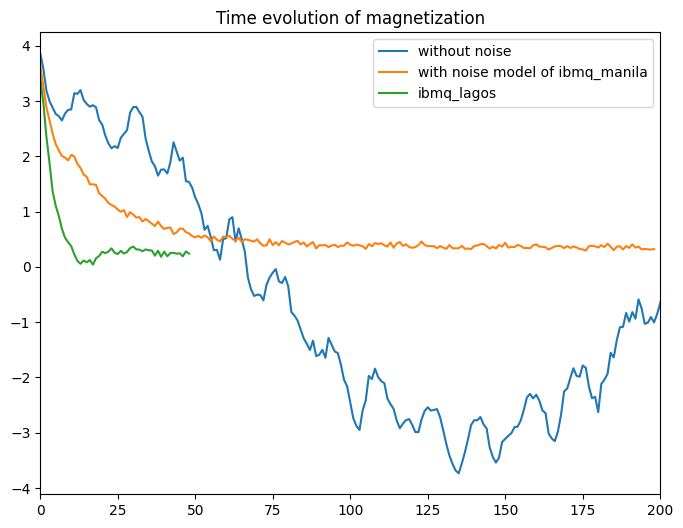

In [ ]:
fig